In [16]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.calibration import calibration_curve
from scipy.stats import binned_statistic


In [13]:
def normalize(y):
    min_val = np.min(y)
    max_val = np.max(y)
    return (y - min_val) / (max_val - min_val)



def random_wave(x: np.ndarray):
    y = np.zeros_like(x)

    for _ in range(np.random.randint(1, 5)):  # Generate between 1 and 4 sine/cosine waves
        amplitude = np.random.uniform(0, 1) 
        frequency = np.random.uniform(1, 10)
        phase = np.random.uniform(0, 2*np.pi)
        y += amplitude * np.sin(2 * np.pi * frequency * x + phase)
        if np.random.rand() < 0.5:  # Randomly add a cosine wave half the time
            y += amplitude * np.cos(2 * np.pi * frequency * x + phase)

    return normalize(y)

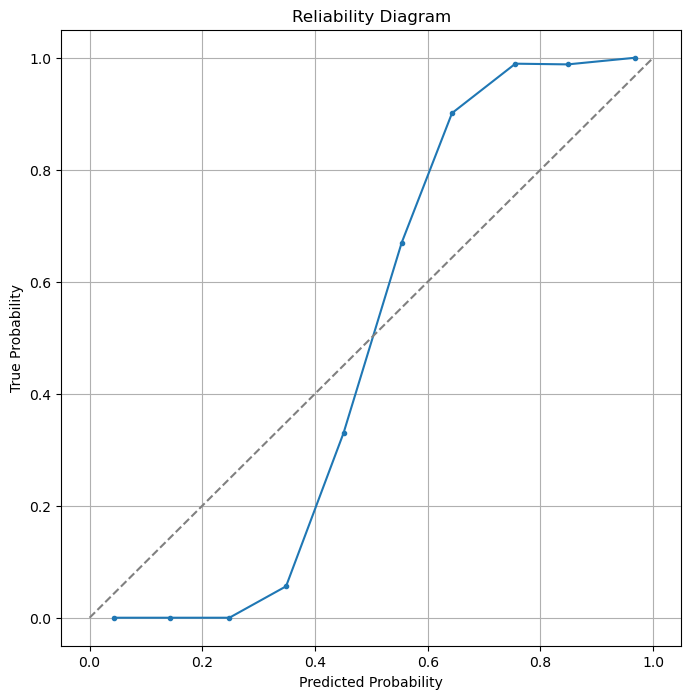

In [14]:

np.random.seed(0)
true_probabilities = np.random.uniform(0, 1, size=1000)
predictions = np.random.normal(loc=true_probabilities, scale=0.1)

# Clip predictions so they fall between 0 and 1
predictions = np.clip(predictions, 0, 1)

# Binarize true probabilities
true_labels = np.where(true_probabilities > 0.5, 1, 0)

# Compute the calibration curve
prob_true, prob_pred = calibration_curve(true_labels, predictions, n_bins=10)

# Plot the calibration curve
plt.figure(figsize=(8, 8))
plt.plot(prob_pred, prob_true, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Reliability Diagram')
plt.grid(True)
plt.show()

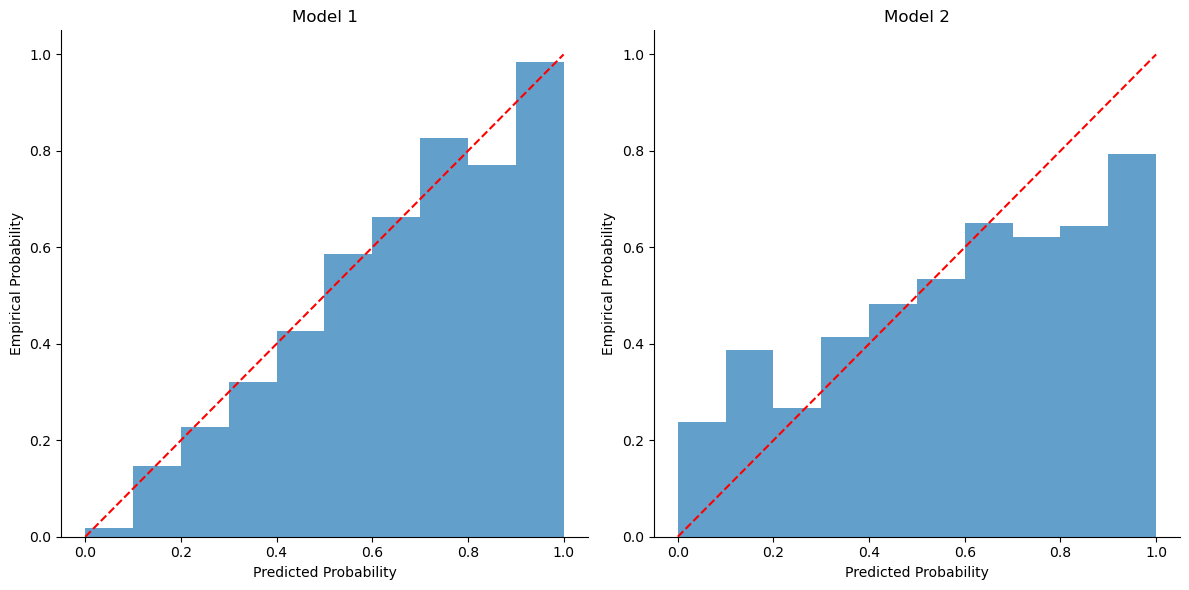

In [25]:

# Generate synthetic data
#np.random.seed(0)
num_patients = 1000

# For a well-calibrated model
true_probabilities_well_calibrated = np.random.uniform(0, 1, size=num_patients)
predictions_well_calibrated = np.random.normal(loc=true_probabilities_well_calibrated, scale=0.1)
predictions_well_calibrated = np.clip(predictions_well_calibrated, 0, 1)
actual_outcomes_well_calibrated = np.random.rand(num_patients) < predictions_well_calibrated

# For a poorly calibrated model
true_probabilities_poorly_calibrated = np.random.uniform(0, 1, size=num_patients)
predictions_poorly_calibrated = np.random.normal(loc=true_probabilities_poorly_calibrated, scale=0.3)
predictions_poorly_calibrated = np.clip(predictions_poorly_calibrated, 0, 1)
actual_outcomes_poorly_calibrated = np.random.rand(num_patients) < true_probabilities_poorly_calibrated

# Bin data and calculate means
bins = np.linspace(0, 1, 11)
bin_centers = (bins[1:] + bins[:-1]) / 2

well_calibrated_means, _, _ = binned_statistic(predictions_well_calibrated, actual_outcomes_well_calibrated, bins=bins)
poorly_calibrated_means, _, _ = binned_statistic(predictions_poorly_calibrated, actual_outcomes_poorly_calibrated, bins=bins)

# Make the plots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

axes[0].bar(bin_centers, well_calibrated_means, width=0.1, align='center', alpha=0.7)
axes[0].plot([0, 1], [0, 1], 'r--')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].set_xlabel('Predicted Probability')
axes[0].set_ylabel('Empirical Probability')
axes[0].set_title('Model 1')

axes[1].bar(bin_centers, poorly_calibrated_means, width=0.1, align='center', alpha=0.7)
axes[1].plot([0, 1], [0, 1], 'r--')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].set_xlabel('Predicted Probability')
axes[1].set_ylabel('Empirical Probability')
axes[1].set_title('Model 2')

plt.tight_layout()
plt.show()

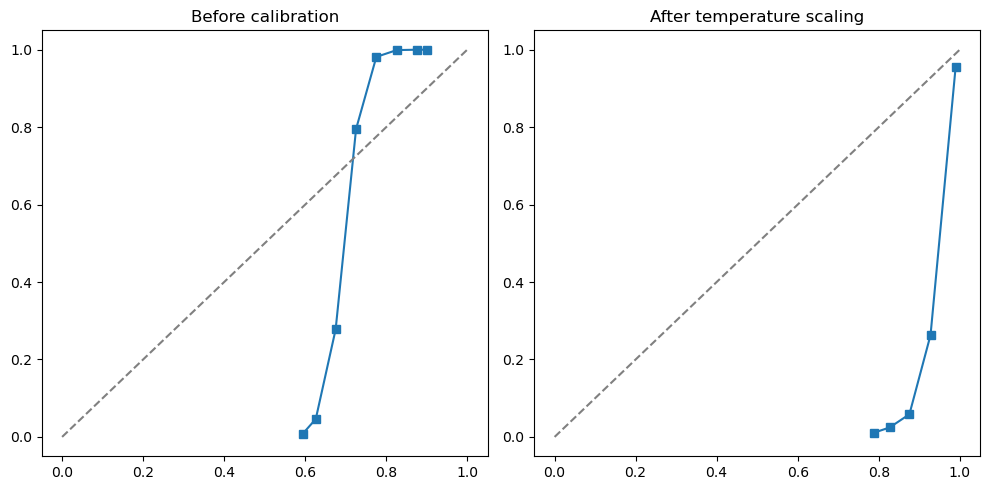

In [29]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

def temp_scale(logits, temperature):
    return torch.nn.functional.softmax(logits / temperature, dim=1)

# Create some random data
n_samples = 5000
X = np.random.rand(n_samples, 1).astype(np.float32)
# True probabilities are a noisy sigmoid function of the inputs
y_true_prob = 1 / (1 + np.exp(-(20*X - 5 + np.random.normal(scale=0.5, size=X.shape))))
y = np.random.binomial(1, y_true_prob)

# PyTorch model: Single-layer neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(1, 2)

    def forward(self, x):
        x = self.fc(x)
        return x

model = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Train model to be over-confident
for epoch in range(200):
    inputs = torch.from_numpy(X)
    labels = torch.from_numpy(y).long()

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels.squeeze())
    loss.backward()
    optimizer.step()

# Get predicted probabilities before calibration
probs_before = torch.nn.functional.softmax(model(inputs), dim=1).detach().numpy()

# Temperature scaling
logits_val = model(inputs).detach()
temperature = torch.tensor(1.0, requires_grad=True) 
optimizer = torch.optim.LBFGS([temperature], lr=0.01, max_iter=50)

def eval():
    loss = criterion(temp_scale(logits_val, temperature), labels.squeeze())
    loss.backward()
    return loss

optimizer.step(eval)

# Get predicted probabilities after calibration
probs_after = temp_scale(logits_val, temperature.detach()).numpy()


# Plot calibration curves
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
fraction_of_positives, mean_predicted_value = calibration_curve(y, probs_before[:, 1], n_bins=20)
plt.plot(mean_predicted_value, fraction_of_positives, "s-")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.title("Before calibration")

plt.subplot(1, 2, 2)
fraction_of_positives, mean_predicted_value = calibration_curve(y, probs_after[:, 1], n_bins=20)
plt.plot(mean_predicted_value, fraction_of_positives, "s-")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.title("After temperature scaling")

plt.tight_layout()
plt.show()